# **Algorithmic Trading: German Electricity Market**

In [12]:
%load_ext autoreload
%autoreload 2

import json
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train = pd.read_hdf('train_val_test.h5', key='train')
val = pd.read_hdf('train_val_test.h5', key='val')
test = pd.read_hdf('train_val_test.h5', key='test')

imbalances = pd.read_csv('imbalances.csv', parse_dates=['date'], index_col=0)
imbalances_val = imbalances.loc[val.index]
imbalances_test = imbalances.loc[test.index]

with open("features.json", "r") as f:
    features = json.load(f)

with open("target.json", "r") as f:
    target = json.load(f)["target"]

In [3]:
X_train_expert = train[features["expert_features"]]
X_test_expert = test[features["expert_features"]]
X_val_expert = val[features["expert_features"]]

X_train_bf = train[features["bf_features"]].dropna()
X_val_bf = val[features["bf_features"]]
X_test_bf = test[features["bf_features"]]
y_train_bf = train.loc[X_train_bf.index, target]

X_train_hybrid = train[features["hybrid_features"]].dropna()
X_val_hybrid = val[features["hybrid_features"]]
X_test_hybrid = test[features["hybrid_features"]]
y_train_hybrid = train.loc[X_train_hybrid.index, target]

y_train = train[target]
y_val = val[target]
y_test = test[target]

## **Hyperparameter tuning & Model Evaluation**

We perform a simple Grid Search to tune a limited set of hyperparameters. The evaluation metric is the cumulative P&L of a trading strategy, where the spread is bought (or sold) when the forecast is positive (or negative). Given the complexity of the task, predicting the direction of the spread proves to be more robust than attempting to predict its exact levels.

In [4]:
def calculate_pnl(row):
    pos_mw = 50
    # Too risky
    if abs(row['imbalances']) > 1000:
        return 0
    if row['pred'] >= 0:
        # If spread >= 0 => Buy 50MW DA (pos_mw > 0) long position
        return pos_mw * row['spread']
    else:
        # If spread < 0 => Sell 50MW DA (pos_mw < 0) short position
        return -pos_mw * row['spread']

def hyperparameter_tuning(model, param_grid, X_train, y_train, X_val, y_val, imbalances_test, spread_val):
    """
    Perform hyperparameter tuning for multiple models using PnL as the evaluation metric.

    Parameters:
    - model: The model instance (e.g., XGBoost, RandomForest).
    - param_grid: Dictionary of hyperparameter grids.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target.
    - X_val (pd.DataFrame): Validation features.
    - y_val (pd.Series): Validation target.
    - imbalances_test (pd.DataFrame): Test data containing the imbalance column.
    - spread_val (pd.DataFrame): Test data containing the spread column.

    Returns:
    - best_params: Hyperparameters that achieved the best cumulative PnL.
    """
    best_params = None
    best_pnl = -float("inf")
    
    param_grid_iter = tqdm(ParameterGrid(param_grid), desc="Hyperparameter Tuning", leave=True)
    for params in param_grid_iter:
        model.set_params(**params)
        model.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
        y_pred = model.predict(X_val.to_numpy())

        results = pd.concat([
            pd.Series(y_pred, index=y_val.index, name="pred"), 
            imbalances_test, y_val, spread_val
        ], axis=1)
        results['pnl'] = results.apply(calculate_pnl, axis=1)
        results['pnl_cumsum'] = results['pnl'].cumsum()
        cumulative_pnl = results['pnl_cumsum'].iloc[-1]
        
        param_grid_iter.set_postfix({
            "P&L": f"{cumulative_pnl:,.2f}",
            **params
        })

        if cumulative_pnl > best_pnl:
            best_params = params
            best_pnl = cumulative_pnl
    
    print("\nTuning completed!")
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Cumulative PnL: {best_pnl:,.2f}€")
    
    return best_params


def evaluate_model(model, best_params, X_train, y_train, X_val, y_val, X_test, y_test, imbalances_test, spread_test):
    """
    Evaluate a model on the test set after training with the best parameters.

    Parameters:
    - model: Trained model instance.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target.
    - X_val (pd.DataFrame): Validation features.
    - y_val (pd.Series): Validation target.
    - X_test (pd.DataFrame): Test features.
    - y_test (pd.Series): Test target.
    - imbalances_test (pd.DataFrame): Test data containing the imbalance and spread columns.

    Returns:
    - test_pnl (float): The cumulative PnL on the test set.
    - concat_test (pd.DataFrame): DataFrame containing test predictions, imbalances, and calculated PnL.
    """
    # Use all available data before test set
    X_combined = pd.concat([X_train, X_val])
    y_combined = pd.concat([y_train, y_val])
    
    model.set_params(**best_params)
    model.fit(X_combined.to_numpy(), y_combined.to_numpy().ravel())
    y_pred_test = model.predict(X_test.to_numpy())

    if getattr(model, "is_sequence_model", False):
        y_test = y_test.iloc[model.seq_len:, :].copy()

    results = pd.concat(
        [pd.Series(y_pred_test, index=y_test.index, name="pred"), imbalances_test, y_test, spread_test],
        axis=1
    )
    
    results['pnl'] = results.apply(calculate_pnl, axis=1)
    results['pnl_cumsum'] = results['pnl'].cumsum()
    
    return results

## **Models: Ensemble Tree models**

In this section, we explore ensemble tree-based models to predict the spread direction effectively. These models are well-suited for tasks involving complex relationships between features and target variables, as they combine the outputs of multiple decision trees to improve accuracy and generalization.
Specifically, we implement Gradient Boosting Decision tree models from **XGBoost** and **LightGBM**, as well as 1 Random Forest model from **Scikit-Learn**.

### **Extreme Gradient Boosting (XGBoost)**

XGBoost is a highly efficient and scalable Gradient Boosting Decision Tree implementation designed for performance and speed. It uses advanced techniques like regularization to prevent overfitting, tree pruning for optimization, and parallel processing for faster training. 

In [13]:
xgb_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 4, 6],
    "learning_rate": [0.05, 0.1, 0.15]
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42)

In [14]:
xgb_best_params = hyperparameter_tuning(
    xgb_model, xgb_params, 
    X_train_expert, y_train, X_val_expert, y_val, 
    imbalances_val, val["spread"])

results_xgb_expert = evaluate_model(
    xgb_model, xgb_best_params, 
    X_train_expert, y_train, X_val_expert, y_val, X_test_expert, y_test, 
    imbalances_test, test["spread"]
)

print(f"\nOut-of-sample Cumulated PnL: {results_xgb_expert['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning:   0%|          | 0/27 [00:00<?, ?it/s]

Hyperparameter Tuning: 100%|██████████| 27/27 [00:07<00:00,  3.39it/s, P&L=4,576,378.00, learning_rate=0.15, max_depth=6, n_estimators=200]



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Cumulative PnL: 7,305,927.00€

Out-of-sample Cumulated PnL: 2,405,678.50€


In [15]:
xgb_best_params = hyperparameter_tuning(
    xgb_model, xgb_params, 
    X_train_bf, y_train_bf, X_val_bf, y_val, 
    imbalances_val, val["spread"]
)

results_xgb_bf = evaluate_model(
    xgb_model, xgb_best_params, 
    X_train_bf, y_train_bf, X_val_bf, y_val, X_test_bf, y_test, 
    imbalances_test, test["spread"]
)

print(f"\nOut-of-sample Cumulated PnL: {results_xgb_bf['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning:   0%|          | 0/27 [00:00<?, ?it/s]

Hyperparameter Tuning: 100%|██████████| 27/27 [00:08<00:00,  3.37it/s, P&L=-237,567.00, learning_rate=0.15, max_depth=6, n_estimators=200]  



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200}
Best Cumulative PnL: 238,132.00€

Out-of-sample Cumulated PnL: 418,962.50€


In [16]:
xgb_best_params = hyperparameter_tuning(
    xgb_model, xgb_params, 
    X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val, 
    imbalances_val, val["spread"]
)

results_xgb_hybrid = evaluate_model(
    xgb_model, xgb_best_params, 
    X_train_hybrid, y_train_bf, X_val_hybrid, y_val, X_test_hybrid, y_test, 
    imbalances_test, test["spread"]
)

print(f"\nOut-of-sample Cumulated PnL: {results_xgb_hybrid['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 27/27 [00:08<00:00,  3.29it/s, P&L=3,105,928.00, learning_rate=0.15, max_depth=6, n_estimators=200]



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 150}
Best Cumulative PnL: 4,730,068.00€

Out-of-sample Cumulated PnL: 2,043,554.50€


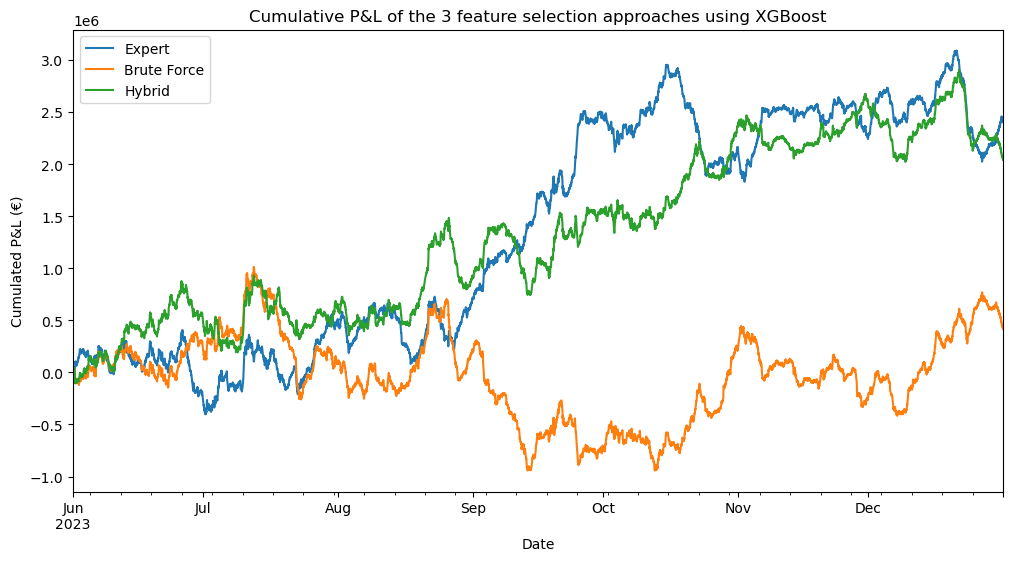

In [17]:
results_xgb_expert['pnl_cumsum'].plot(figsize=(12, 6), label="Expert")
results_xgb_bf['pnl_cumsum'].plot(figsize=(12, 6), label="Brute Force")
results_xgb_hybrid['pnl_cumsum'].plot(figsize=(12, 6), label="Hybrid")
plt.ylabel("Cumulated P&L (€)")
plt.title("Cumulative P&L of the 3 feature selection approaches using XGBoost")
plt.legend()
plt.show()

The **Expert** and **Hybrid** feature selection approaches show similar performance, whereas the **Brute Force** approach begins to underperform starting in September.

### **LightGBM (LGB)**

LightGBM is a gradient boosting framework specifically optimized for efficiency and speed, making it ideal for large datasets. It uses **histogram-based learning** and **leaf-wise tree growth**, which allow it to handle high-dimensional data and reduce training time significantly. 

In [18]:
lgb_params = {
    "n_estimators": [150, 200, 250, 300],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2]
}

lgb_model = lgb.LGBMRegressor(objective="regression", random_state=42, n_jobs=-1, verbose=-1)

In [19]:
lgb_best_params = hyperparameter_tuning(
    lgb_model, lgb_params,
    X_train_expert, y_train, X_val_expert, y_val,
    imbalances_val, val["spread"]
)

results_lgb_expert = evaluate_model(
    lgb_model, lgb_best_params, 
    X_train_expert, y_train, X_val_expert, y_val, X_test_expert, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_lgb_expert['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 64/64 [00:47<00:00,  1.34it/s, P&L=3,513,607.00, learning_rate=0.2, max_depth=8, n_estimators=300] 



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Cumulative PnL: 6,591,790.00€

Out-of-sample Cumulated PnL: 1,226,581.50€


In [20]:
lgb_best_params = hyperparameter_tuning(
    lgb_model, lgb_params,
    X_train_bf, y_train_bf, X_val_bf, y_val,
    imbalances_val, val["spread"]
)

results_lgb_bf = evaluate_model(
    lgb_model, lgb_best_params, 
    X_train_bf, y_train_bf, X_val_bf, y_val, X_test_bf, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_lgb_bf['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 64/64 [00:48<00:00,  1.31it/s, P&L=-4,338,739.00, learning_rate=0.2, max_depth=8, n_estimators=300] 



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 150}
Best Cumulative PnL: 519,199.00€

Out-of-sample Cumulated PnL: -3,463,593.50€


In [21]:
lgb_best_params = hyperparameter_tuning(
    lgb_model, lgb_params,
    X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val,
    imbalances_val, val["spread"]
)

results_lgb_hybrid = evaluate_model(
    lgb_model, lgb_best_params, 
    X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val, X_test_hybrid, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_lgb_hybrid['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s, P&L=922,134.00, learning_rate=0.2, max_depth=8, n_estimators=300]   



Tuning completed!
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 250}
Best Cumulative PnL: 3,022,158.00€

Out-of-sample Cumulated PnL: 2,599,424.50€


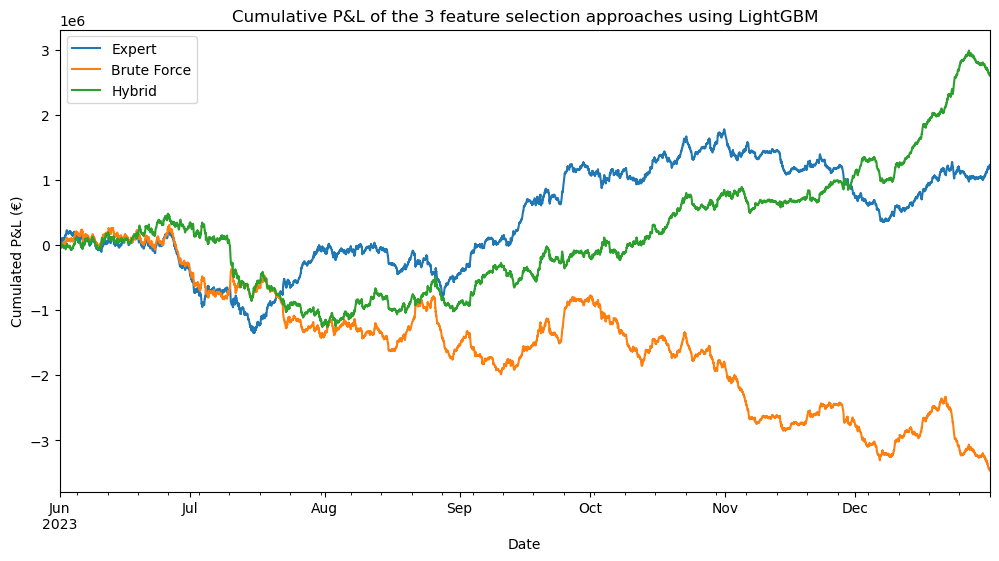

In [22]:
results_lgb_expert['pnl_cumsum'].plot(figsize=(12, 6), label="Expert")
results_lgb_bf['pnl_cumsum'].plot(figsize=(12, 6), label="Brute Force")
results_lgb_hybrid['pnl_cumsum'].plot(figsize=(12, 6), label="Hybrid")
plt.ylabel("Cumulated P&L (€)")
plt.title("Cumulative P&L of the 3 feature selection approaches using LightGBM")
plt.legend()
plt.show()

The cumulative P&L plot shows that the Hybrid and Expert approaches perform significantly better, with the Hybrid method leading overall. In contrast, the Brute Force approach declines steadily after July, resulting in substantial losses.

### **Random Forest (RF)**

Random Forest is an ensemble method that builds multiple decision trees and combines their outputs to improve robustness and accuracy. It reduces overfitting by using **bootstrap aggregation (bagging)**, where each tree is trained on a random subset of the data and features. The final prediction is obtained by taking the average of predicitons across all trees, making Random Forest highly effective for noisy and complex datasets.

In [5]:
rf_params = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [3, 4, 6],             # Maximum depth of trees
    "min_samples_split": [2, 5, 10]       # Minimum samples required to split a node
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [6]:
rf_best_params = hyperparameter_tuning(
    rf_model, rf_params,
    X_train_expert, y_train, X_val_expert, y_val,
    imbalances_val, val["spread"]
)

results_rf_expert = evaluate_model(
    rf_model, rf_best_params, 
    X_train_expert, y_train, X_val_expert, y_val, X_test_expert, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_rf_expert['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 27/27 [01:40<00:00,  3.73s/it, P&L=6,117,386.00, max_depth=6, min_samples_split=10, n_estimators=300]



Tuning completed!
Best Hyperparameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best Cumulative PnL: 6,571,661.00€

Out-of-sample Cumulated PnL: 3,537,299.50€


In [7]:
rf_best_params = hyperparameter_tuning(
    rf_model, rf_params,
    X_train_bf, y_train_bf, X_val_bf, y_val,
    imbalances_val, val["spread"]
)

results_rf_bf = evaluate_model(
    rf_model, rf_best_params, 
    X_train_bf, y_train_bf, X_val_bf, y_val, X_test_bf, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_rf_bf['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning:   0%|          | 0/27 [00:00<?, ?it/s]

Hyperparameter Tuning: 100%|██████████| 27/27 [02:15<00:00,  5.02s/it, P&L=362,770.00, max_depth=6, min_samples_split=10, n_estimators=300]  



Tuning completed!
Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best Cumulative PnL: 4,990,834.00€

Out-of-sample Cumulated PnL: -3,319,898.50€


In [8]:
rf_best_params = hyperparameter_tuning(
    rf_model, rf_params,
    X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val,
    imbalances_val, val["spread"]
)

results_rf_hybrid = evaluate_model(
    rf_model, rf_best_params, 
    X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val, X_test_hybrid, y_test, 
    imbalances_test, test["spread"]
)
print(f"\nOut-of-sample Cumulated PnL: {results_rf_hybrid['pnl_cumsum'].iloc[-1]:,.2f}€")

Hyperparameter Tuning: 100%|██████████| 27/27 [02:34<00:00,  5.72s/it, P&L=1,880,077.00, max_depth=6, min_samples_split=10, n_estimators=300]



Tuning completed!
Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best Cumulative PnL: 6,113,723.00€

Out-of-sample Cumulated PnL: -3,778,895.50€


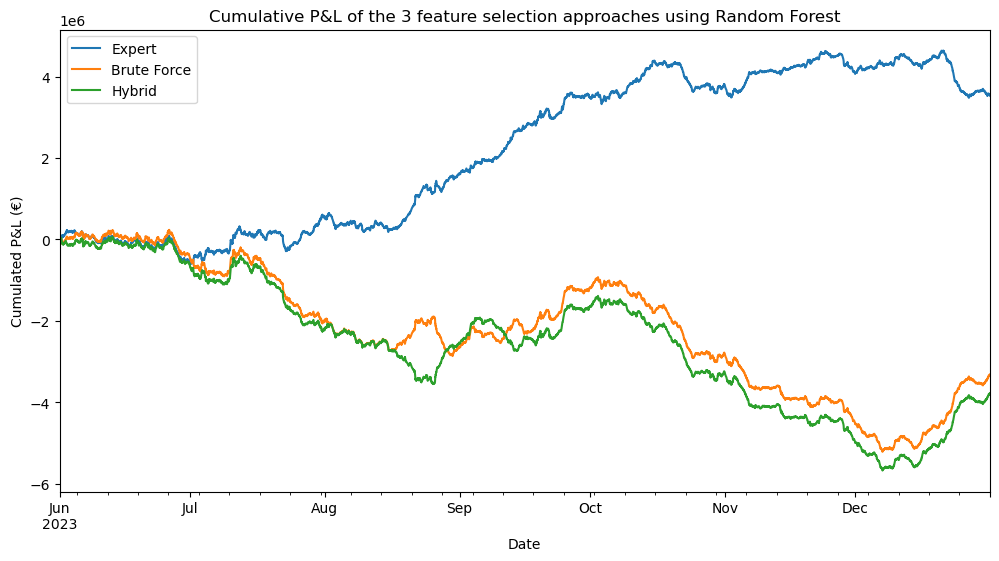

In [9]:
results_rf_expert['pnl_cumsum'].plot(figsize=(12, 6), label="Expert")
results_rf_bf['pnl_cumsum'].plot(figsize=(12, 6), label="Brute Force")
results_rf_hybrid['pnl_cumsum'].plot(figsize=(12, 6), label="Hybrid")
plt.ylabel("Cumulated P&L (€)")
plt.title("Cumulative P&L of the 3 feature selection approaches using Random Forest")
plt.legend()
plt.show()

The cumulative P&L plot shows that the **Expert** approach outperforms significantly, with steady gains throughout the period. In contrast, both the **Brute Force** and **Hybrid** methods decline after July, resulting in substantial losses, 

### **Model Comparison**

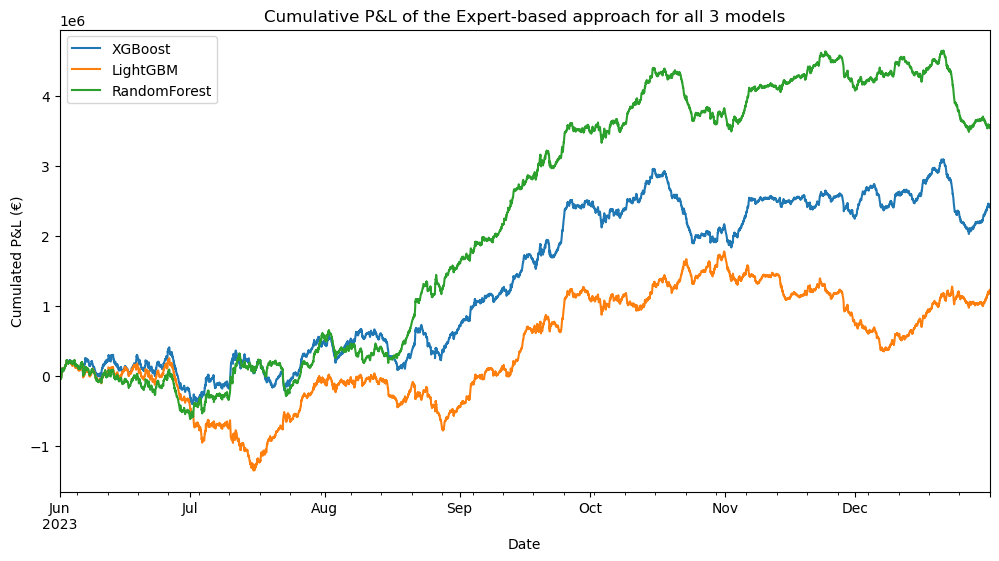

In [29]:
results_xgb_expert['pnl_cumsum'].plot(figsize=(12, 6), label="XGBoost")
results_lgb_expert['pnl_cumsum'].plot(figsize=(12, 6), label="LightGBM")
results_rf_expert['pnl_cumsum'].plot(figsize=(12, 6), label="RandomForest")
plt.ylabel("Cumulated P&L (€)")
plt.title("Cumulative P&L of the Expert-based approach for all 3 models")
plt.legend()

The cumulative P&L plot shows that Random Forest achieves the best performance, with strong and consistent gains from August onward. XGBoost performs well but lags behind Random Forest, maintaining steady growth. In contrast, LightGBM underperforms, showing a decline in July and only modest recovery afterward.